# Carga de datos problema

- Los vehiculos son heterogeneos pero a partir del planteamiento propuesto su consumo de gasolina es el mismo ya que no hay una diferencia en la capacidad lo suficientmente significativa para que se genere un cambio. Resulta que en el problema que se nos es presentado. Todos los vehiculos del problema entran en la misma categoria de consumo de gasolina. La primera de todas ningun vehiculo supera esta categoria. Es por ello que se ajusta el modelado propuesto para poder obtener resultados interesantes y lograr aplicar el caso con vehículos heterogeneos. 
Es así, como a continuación se presenta la tabla que muestra los valores que se utilizaron:

| Capacidad | Consumo (L/Km) | 
|----------|----------|
| >50    | 0.411458  | 
| 75<x<50    | 0.435105   | 
| 100<x<75   | 0.473176 | 
| +100 | 0.484688 | 




In [79]:
import numpy as np
from pyomo.environ import *
import pandas as pd
import folium
import matplotlib.pyplot as plt
from statistics import mean, stdev

In [28]:
def load_distance_time_matrix(path, N):
    data= pd.read_csv(path)
    distance = np.zeros((N,N))
    time = np.zeros((N,N))
    
    for i in range(len(data)):
        origen = int(data.iloc[i, 0])
        destino = int(data.iloc[i, 1])
        distance[origen-1, destino-1] = float(data.iloc[i, 2])
        time[origen-1, destino-1] = float(data.iloc[i, 3])
    return distance, time

def load_vehicles(path):
    data= pd.read_csv(path)
    N = len(data)
    vehicles = {}
    for i in range(N):
        id = int(data.iloc[i, 0])
        capacity = int(data.iloc[i, 1])
        ran = float(data.iloc[i, 2])
        vehicles[id] = (capacity, ran)
    
    return vehicles

def load_demand(clientsPath):
    data= pd.read_csv(clientsPath)
    N = len(data)
    demand_dic = {}
    for i in range(N):
        id = int(data.iloc[i, 1])
        demand = float(data.iloc[i, 2])
        demand_dic[id] = demand
    
    return demand_dic


def load_capacity(depositPath):
    data= pd.read_csv(depositPath)
    N = len(data)
    capacity_dic = {}
    for i in range(N):
        id = int(data.iloc[i, 1])
        capacity = float(data.iloc[i, 4])
        capacity_dic[id] = capacity
    
    return capacity_dic

def load_distance_time_dic(path):
    data= pd.read_csv(path)
    distance = {}
    time = {}
    
    for i in range(len(data)):
        origen = int(data.iloc[i, 0])
        destino = int(data.iloc[i, 1])
        distance[origen, destino] = float(data.iloc[i, 2])
        time[origen, destino] = float(data.iloc[i, 3])
    
    return distance, time

def load_coordinates(depotsPath, clientsPath):
    coord = {}
    depot= pd.read_csv(depotsPath)
    client= pd.read_csv(clientsPath)
    
    for i in range(len(depot)):
        id = int(depot.iloc[i, 1])
        lat = float(depot.iloc[i, 3])
        long = float(depot.iloc[i, 2])
        coord[id] = [lat, long]

    for j in range(len(client)):
        id = int(client.iloc[j, 1])
        lat = float(client.iloc[j, 4])
        long = float(client.iloc[j, 3])
        coord[id] = [lat, long]
    
    return coord
        

In [29]:
#Cargar datos
distancia,time_dic = load_distance_time_dic('../Datos/Caso3/caso3.csv')
vehiculos = load_vehicles('../Datos/Caso3/vehicles.csv')
demanda = load_demand('..\Datos\Caso3\clients.csv')
oferta = load_capacity('..\Datos\Caso3\depots.csv')
coord = load_coordinates('..\Datos\Caso3\depots.csv', '..\Datos\Caso3\clients.csv')

print(f"Distancia: {distancia}")
print(f"Vehiculos: {vehiculos}")
print(f"Oferta: {oferta}")
print(f"Demanda: {demanda}")
print(f"Coordenadas: {coord}")


Distancia: {(1, 2): 33061.2, (1, 3): 10160.7, (1, 4): 6452.9, (1, 5): 21415.6, (1, 6): 16924.1, (1, 7): 20126.9, (1, 8): 11361.2, (1, 9): 4329.9, (1, 10): 31289.5, (1, 11): 13659.0, (1, 12): 26223.2, (1, 13): 16323.5, (1, 14): 10339.3, (1, 15): 20151.1, (1, 16): 9069.0, (1, 17): 13001.1, (1, 18): 11585.9, (1, 19): 5611.1, (1, 20): 35182.4, (1, 21): 5382.8, (1, 22): 15080.8, (1, 23): 15604.8, (1, 24): 17375.6, (1, 25): 18066.4, (1, 26): 15519.7, (1, 27): 22099.1, (1, 28): 21116.6, (1, 29): 18265.0, (1, 30): 24161.7, (1, 31): 22148.0, (1, 32): 11296.0, (1, 33): 7930.6, (1, 34): 25061.6, (1, 35): 23030.4, (1, 36): 18832.4, (1, 37): 30974.4, (1, 38): 15263.2, (1, 39): 26853.9, (1, 40): 19256.8, (1, 41): 7132.5, (1, 42): 18337.4, (1, 43): 14053.1, (1, 44): 14476.5, (1, 45): 22832.7, (1, 46): 22156.7, (1, 47): 20648.7, (1, 48): 28891.8, (1, 49): 23837.9, (1, 50): 14339.2, (1, 51): 18236.1, (1, 52): 11772.5, (1, 53): 11658.8, (1, 54): 23255.9, (1, 55): 17080.0, (1, 56): 11591.1, (1, 57): 2327

# División aproximada del problema 

In [30]:
def asignar_clientes_con_distribucion_parcial(
    matriz_distancias: dict,
    n_centros: int,
    k_total: int,
    capacidades: dict,
    demandas: dict
) -> dict:
    # Inicializar asignaciones y copia de capacidad
    asignaciones = {centro: {centro:0} for centro in range(1, n_centros + 1)}
    capacidad_restante = capacidades.copy()

    # Iterar sobre cada cliente
    for cliente in range(n_centros + 1, k_total + 1):
        demanda_restante = demandas.get(cliente, 0)

        # Ordenar centros por cercanía al cliente
        centros_ordenados = sorted(
            range(1, n_centros + 1),
            key=lambda c: matriz_distancias.get((c, cliente), float('inf'))
        )

        # Intentar asignación completa primero
        asignado_completo = False
        for centro in centros_ordenados:
            if capacidad_restante[centro] >= demanda_restante:
                distancia = matriz_distancias.get((centro, cliente), float('inf'))
                asignaciones[centro][cliente] = distancia
                capacidad_restante[centro] -= demanda_restante
                asignado_completo = True
                break

        # Si no se asignó completamente, hacer asignación parcial
        if not asignado_completo:
            for centro in centros_ordenados:
                capacidad = capacidad_restante[centro]
                if capacidad > 0 and demanda_restante > 0:
                    porcion_asignada = min(demanda_restante, capacidad)
                    distancia = matriz_distancias.get((centro, cliente), float('inf'))

                    # Guardar como cliente_parcial si ya tiene una parte asignada
                    clave_cliente = cliente if cliente not in asignaciones[centro] else cliente

                    # Aquí asumimos que las distancias representan la asignación del cliente total,
                    # pero si quieres guardar "cuánto" se asignó, podemos cambiar el formato.

                    if clave_cliente not in asignaciones[centro]:
                        asignaciones[centro][clave_cliente] =  porcion_asignada
                            
                        
                    else:
                        asignaciones[centro][clave_cliente]['asignado'] += porcion_asignada

                    capacidad_restante[centro] -= porcion_asignada
                    demanda_restante -= porcion_asignada

                if demanda_restante <= 0:
                    break

    return asignaciones


In [31]:


asignacionclientes = asignar_clientes_con_distribucion_parcial(
    distancia,
    n_centros=12,
    k_total=102,
    capacidades=oferta,
    demandas=demanda
)

from pprint import pprint
pprint(asignacionclientes)

def en_mismo_grupo(i, j, grupos):
    return any(i in grupo and j in grupo for grupo in grupos.values())




{1: {1: 0},
 2: {2: 0, 95: 4785.6, 98: 7904.5},
 3: {3: 0, 17: 5982.0, 18: 7006.2, 43: 4695.9, 89: 5659.4},
 4: {4: 0,
     14: 9159.2,
     16: 7094.7,
     19: 423.3,
     24: 11251.3,
     32: 7707.7,
     53: 8070.5,
     59: 7816.7,
     70: 5238.2,
     75: 7786.9,
     78: 6160.6,
     79: 2441.8,
     81: 6291.8},
 5: {5: 0,
     15: 2510.4,
     28: 1235.9,
     29: 5829.2,
     30: 3024.0,
     31: 7443.7,
     40: 3408.4,
     45: 10776.5,
     54: 10239.8,
     57: 1478.9,
     58: 6948.4,
     60: 946.4,
     63: 2947.8,
     72: 6428.0,
     76: 8198.4,
     77: 8721.4,
     88: 8350.6},
 6: {6: 0,
     13: 6114.6,
     23: 5833.4,
     25: 6417.2,
     38: 3638.3,
     42: 3030.2,
     67: 3216.0,
     87: 7773.8,
     97: 3049.4,
     99: 6161.8},
 7: {7: 0,
     22: 8057.1,
     26: 8878.7,
     27: 2994.5,
     35: 3822.0,
     36: 3692.8,
     46: 2898.1,
     47: 5609.3,
     51: 3913.6,
     55: 5957.8,
     68: 3319.7,
     71: 3118.6,
     84: 11279.5,
     85: 6

## Modelado del problema

In [32]:
gv1 = 0.411458
gv2 = 0.435105
gv3 = 0.473176
gv4= 0.484688
gv = {}
for i in vehiculos:
    if vehiculos[i][0] <= 50:
        gv[i] = gv1
    elif vehiculos[i][0] > 50 and vehiculos[i][0] <= 75:
        gv[i] = gv2
    elif vehiculos[i][0] > 75 and vehiculos[i][0] <= 100:
        gv[i] = gv3
    else:
        gv[i] = gv4


In [33]:
pf = 15000
ft = 5000
cm = 700


# Modelo
model = ConcreteModel()

# Conjuntos
model.D = Set(initialize=oferta.keys())   # Depósitos
model.C = Set(initialize=demanda.keys())  # Clientes
model.N = Set(initialize=list(model.D) + list(model.C))  # Todos los nodos
model.K = Set(initialize=vehiculos.keys())  # Vehículos

#Filtrar indices usados
indices_usados = [(i, j, k) for i in model.N for j in model.N for k in model.N if en_mismo_grupo(i,j,asignacionclientes)]
model.IndUs = Set(dimen=3, initialize=indices_usados)


# Parámetros
model.distancia = Param(model.N, model.N, initialize=lambda model, i, j: distancia.get((i,j), 0))
model.capacidad = Param(model.K, initialize=lambda model, k: vehiculos[k][0])
model.demanda = Param(model.C, initialize=demanda)
model.oferta = Param(model.D, initialize=oferta)

# Variables
model.x = Var(model.IndUs, within=Binary)  # Arco i-j servido por vehículo k
model.y = Var(model.C, model.K, within=NonNegativeReals) # Cantidad entregada a cliente j por vehículo k
model.u = Var(model.C, within=NonNegativeIntegers)       # Variables para eliminar subciclos




# Función objetivo
def obj_rule(model):
    return sum(gv[k]*pf +ft+cm*model.distancia[i,j] * model.x[i,j,k] for i in model.N for j in model.N for k in model.K if i != j and (i,j,k) in model.IndUs )
model.obj = Objective(rule=obj_rule, sense=minimize)

# Restricciones
def demanda_satisfecha_rule(model, j):
    return sum(model.y[j,k] for k in model.K) == model.demanda[j]
model.demanda_satisfecha = Constraint(model.C, rule=demanda_satisfecha_rule)

def capacidad_vehiculo_rule(model, k):
    return sum(model.y[j,k] for j in model.C) <= model.capacidad[k]
model.capacidad_vehiculo = Constraint(model.K, rule=capacidad_vehiculo_rule)

def flujo_entrada_salida_rule(model, j, k):
    entradas = [(i, j, k) for i in model.N if i != j and (i, j, k) in model.IndUs]
    salidas  = [(j, i, k) for i in model.N if i != j and (j, i, k) in model.IndUs]

    if not entradas and not salidas:
        return Constraint.Skip

    entrada = sum(model.x[i, j, k] for (i, j, k) in entradas)
    salida  = sum(model.x[j, i, k] for (j, i, k) in salidas)

    return entrada == salida

   
model.flujo_entrada_salida = Constraint(model.N, model.K, rule=flujo_entrada_salida_rule)

def salida_deposito_rule(model, d, k):
    lados_izq = [(d,j,k) for j in model.C if (d,j,k) in model.IndUs]
    if not lados_izq:
        return Constraint.Skip
    lado_izq = sum(model.x[d,j,k] for (i,j,k) in lados_izq)
    return  lado_izq <= 1  # Máximo 1 ruta que sale del depósito d por vehículo k
model.salida_deposito = Constraint(model.D, model.K, rule=salida_deposito_rule)

def subtour_elimination_rule(model, i, j):
    if i != j and i in model.C and j in model.C:
        return model.u[i] - model.u[j] + len(model.C)*sum(model.x[i,j,k] for k in model.K if (i,j,k) in model.IndUs) <= len(model.C) - 1
    else:
        return Constraint.Skip
model.subtour_elimination = Constraint(model.N, model.N, rule=subtour_elimination_rule)

def asignacion_unica_rule(model, j):
    if j in model.C:
        return sum(model.x[i,j,k] for i in model.N for k in model.K if i != j and (i,j,k) in model.IndUs) == 1
    else:
        return Constraint.Skip
model.asignacion_unica = Constraint(model.N, rule=asignacion_unica_rule)

def solucionaprox_rule(model,i,j,k):
    if i == 1 :
        return model.x[i,j,k] == 0
    elif i == 2 and (j != 95 or j != 98 ):
        return model.x[i,j,k] == 0
    elif i ==3 and (j != 17 or j !=18 or j != 43 or j != 89 ):
        return model.x[i,j,k] == 0
    elif i ==4 and j not in {14,16,19,24,32,53,59,70,75,78,79,81}:
        return model.x[i,j,k] == 0
    elif i ==5 and j not in {15,28,29,30,31,40,45,54,57,58,60,63,72,76,77,88} :
        return model.x[i,j,k] == 0
    elif i ==6 and j not in {13,23,25,38,42,67,87,97,99}:
        return model.x[i,j,k] == 0
    elif i ==7 and j not in {22,26,27,35,36,46,47,51,55,68,71,84,85,94,96,101,102}:
        return model.x[i,j,k] == 0
    elif i ==8 and j not in {44,50,56,62}:
        return model.x[i,j,k] == 0
    elif i ==9 and j not in {21,33,41,61,73}:
        return model.x[i,j,k] == 0
    elif i ==10 and j not in {37,39,64,65,82,92}:
        return model.x[i,j,k] == 0
    elif i ==11 and j not in {52,69,74,83,86,90,93}:
        return model.x[i,j,k] == 0
    elif i ==12 and j not in {20,34,48,49,66,80,91,100}:
        return model.x[i,j,k] == 0


# Resolver
# Resolver
solver = SolverFactory('gurobi')
solver.options['TimeLimit'] = 1200  # Establecer límite de tiempo en segundos
solver.options['MIPGap'] = 0.035  # Establecer tolerancia de optimalidad
solver.options['Threads'] = 4  # Número de hilos a usar

# Parámetros importantes:
#solver.options['Threads'] = 5  # Número de hilos a usar (ajusta según tu CPU)
results = solver.solve(model, tee=True)  # tee=True muestra el progreso en consola
# Mostrar resultados
if results.solver.termination_condition == TerminationCondition.optimal:
    print("Solución óptima encontrada")
    print("Valor de la función objetivo:", model.obj())
    
    routes_dict = {}  # Guardamos las rutas en coordenadas para folium

    for v in model.K:
        print(f"\nVehículo {v}:")
        
        active_arcs = [
            (i, j)
            for (i, j, k) in model.IndUs
            if k == v and model.x[i, j, k].value is not None and model.x[i, j, k].value > 0.5
        ]

        
        if not active_arcs:
            print("  No utilizado")
            routes_dict[v] = []
            continue
        
        route_nodes = []
        current = next((i for i,j in active_arcs if i in model.D), active_arcs[0][0])
        route_nodes.append(current)
        remaining_arcs = active_arcs.copy()

        while remaining_arcs:
            next_arc = next((a for a in remaining_arcs if a[0] == current), None)
            if next_arc:
                current = next_arc[1]
                route_nodes.append(current)
                remaining_arcs.remove(next_arc)
            else:
                break

        # Mostrar ruta ordenada
        print(" -> ".join(str(node) for node in route_nodes))

        # Mostrar demanda atendida
        for i in range(len(route_nodes)-1):
            origen = route_nodes[i]
            destino = route_nodes[i+1]
            if destino in model.C:
                print(f"  {origen}->{destino}: Atiende cliente {destino} (Demanda: {model.demanda[destino]})")
            else:
                print(f"  {origen}->{destino}")

        # Guardar coordenadas de la ruta para folium
        if 'coord' in globals():
            routes_dict[v] = [coord[nodo] for nodo in route_nodes]
        else:
            print("Falta el diccionario 'coordenadas' para graficar en folium.")
            routes_dict[v] = []      


else:
    print("No se encontró solución óptima")
    print("Estado del solver:", results.solver.termination_condition)

Read LP format model from file C:\Users\laura\AppData\Local\Temp\tmpq0lmz4xc.pyomo.lp
Reading time = 0.13 seconds
x1: 11580 rows, 34891 columns, 144420 nonzeros
Set parameter TimeLimit to value 1200
Set parameter MIPGap to value 0.035
Set parameter Threads to value 4
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  1200
MIPGap  0.035
Threads  4

Optimize a model with 11580 rows, 34891 columns and 144420 nonzeros
Model fingerprint: 0xb082386d
Variable types: 2701 continuous, 32190 integer (32100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+05, 4e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 120 rows and 2701 columns
Presolve time: 0.25s
Presolved: 11460 rows, 32190 columns, 

# Archivo de validación

In [34]:
import re


data = {
    'VehicleId':[] ,
    'DepotId':[] ,
    'InitialLoad':[] ,
    'RouteSequence':[] ,
    'ClientsServed':[] ,
    'DemandsSatisfied':[] , 
    'TotalDistance':[] , 
    'TotalTime':[] , 
    'FuelCost':[]
}

def isClient(name):
    return bool(re.fullmatch(r'C\d+', name))

for v in model.K:
    path = []
     
    
    active_arcs = [
    (i, j)
    for (i, j, k) in model.IndUs
    if k == v and model.x[i, j, k].value is not None and model.x[i, j, k].value > 0.5
]

    
    if not active_arcs:
        routes_dict[v] = []
        continue
    
    data['VehicleId'].append("VEH" + "{:03d}".format(v))
    route_nodes = []
    current = next((i for i,j in active_arcs if i in model.D), active_arcs[0][0])
    if current in model.C:
        name = "C" + str(current)
    else:
        name = "CD" + str(current)
        data['DepotId'].append(name)
    route_nodes.append(name)
    remaining_arcs = active_arcs.copy()


    while remaining_arcs:
        next_arc = next((a for a in remaining_arcs if a[0] == current), None)
        if next_arc:
            current = next_arc[1]
            if current in model.C:
                name = "C" + str(current)
            else:
                name = "CD" + str(current)
            route_nodes.append(name)
            remaining_arcs.remove(next_arc)
        else:
            break
    
    total_dist = 0
    t_time = 0
    for i, j in active_arcs:
        total_dist += distancia[(i,j)]
        t_time += time_dic[(i,j)]

    data['TotalDistance'].append(round(total_dist/1000,1))
    data['TotalTime'].append(round(t_time, 1))
    data['FuelCost'].append(round((total_dist/1000)*pf))
    print("time", t_time)

    seq = "-".join(str(node) for node in route_nodes)
    print(seq)
    clientsServe = 0
    demandsS = []
    init_load = 0
    for node in route_nodes:
        if isClient(node):
            clientsServe += 1
            demandsS.append(demanda[int(node.split('C')[1].strip())])
            init_load += demanda[int(node.split('C')[1].strip())]
    #print(clientsServe)
    print(demandsS)
    dema = "-".join(str(d) for d in demandsS)
    #print(seq)
    data['RouteSequence'].append(seq)
    data['ClientsServed'].append(clientsServe)
    data['DemandsSatisfied'].append(dema)
    data['InitialLoad'].append(init_load)   

print(data)
df = pd.DataFrame(data)
df.to_csv("verificacion_caso3.csv", index=False)
    
    

#print(data)

time 9794.400000000003
CD4-C19-C79-C78-C16-C59-C14-C70-CD4
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
time 4157.5
CD3-C43-C17-C89-C18-CD3
[11.0, 12.0, 12.0, 12.0]
time 6885.4
CD4-C75-C24-C53-C32-C81-CD4
[12.0, 12.0, 12.0, 12.0, 12.0]
time 2777.2
CD2-C95-C98-CD2
[12.0, 12.0]
time 2737.7000000000003
CD10-C82-C39-C92-C64-C65-C37-CD10
[12.0, 12.0, 5.0, 12.0, 12.0, 12.0]
time 4682.700000000001
CD11-C74-C83-C90-C52-C93-C86-C69-CD11
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 9.0]
time 3671.4000000000005
CD12-C49-C66-C80-C100-C20-C48-C34-C91-CD12
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
time 3809.5
CD6-C13-C87-C23-C38-C99-C25-C67-C42-C97-CD6
[12.0, 12.0, 12.0, 12.0, 10.0, 8.0, 12.0, 12.0, 12.0]
time 1679.3000000000002
CD9-C73-C61-C41-C33-C21-CD9
[12.0, 12.0, 12.0, 12.0, 12.0]
{'VehicleId': ['VEH001', 'VEH004', 'VEH009', 'VEH011', 'VEH013', 'VEH022', 'VEH023', 'VEH027', 'VEH028'], 'DepotId': ['CD4', 'CD3', 'CD4', 'CD2', 'CD10', 'CD11', 'CD12', 'CD6', 'CD9'], 'InitialLoad': [84.0, 47.0, 60.0, 

In [35]:
import folium

m = folium.Map(
    location=[4.743359, -74.153536],  # Puedes centrarlo dinámicamente si gustas
    zoom_start=12,
    tiles='Cartodb Positron'
)

colors = ['blue', 'green', 'cyan', 'magenta', 'olive', 'orange', 'purple', 'red', 'darkred']
icons = ['blue', 'green', 'lightblue', 'pink', 'lightgreen', 'orange', 'darkpurple', 'red', 'darkred']

for v, coords in routes_dict.items():
    if len(coords) > 1:
        folium.PolyLine(
            coords,
            color=colors[int(v) % len(colors)],
            weight=5,
            opacity=0.8,
            tooltip=f"Vehículo {v}"
        ).add_to(m)

        folium.Marker(
            location=coords[0],
            popup=f"Inicio V{v}",
            icon=folium.Icon(color='black')
        ).add_to(m)

        folium.Marker(
            location=coords[-1],
            popup=f"Fin V{v}",
            icon=folium.Icon(color=icons[int(v) % len(icons)])
        ).add_to(m)
m


In [36]:
print()

# Particion del problema
Para poder resolver el problema de un mayor tamaño se decidió optar por la reducción de soluciones posibles. Esto se hizo reduciendo el tamaño mismo del modelo, eliminando variables y restricciones que por la aproximación de la solución no se iban a utilizar. El proceso seguido se detalla a continuación.

- Para reducir el espacio de soluciones se le fueron asignados a cada deposito sus clientes. Esto reduce considerablemente las variables a utilizar. Por ejemplo si al cliente 1 se le asignó el deposito 2. Ya se sabe que las variables que involucren el cliente 1 con cualquier otro deposito serán 0. Es por esto que estas variables no se crean en el modelo.

- Si las variables no se crean esto repercute tanto en la función objetivo como en las restricciones. Primero, si hay menos variables entonces la función objetivo tiene menos variables que solucionar. Esto hace que el espacio de posibles soluciones sea más pequeño y por ende se pueda llegar a una solución aproximada de manera más rápida. 

- Un trade off de esta aproximación es la probabilidad que con la reducción de soluciones posibles al problema no se está llegando al optimo del problema, ya que el óptimo del espacio de soluciones reducido que se ha planteado para el problema no sea el óptimo del problema prinicipal que se quiere solucionar. Esto a cambio de una posible solución en un tiempo reducido.

- Se probaron múltiples solucionadores MIP/LP entre los que se encuentran: GLPK, Coin CBC, Appsi HIGHS, CPLEX y gurobi. Y el único que pudo dar una solución aproximada al problema fue el solver de gurobi. Por lo que para este tipo de problemas tan extensos. (ya que la matriz de distancias tiene miles de elementos), no se recomienda solucionarlo por medio de solucionadores MIP/LP. Otro tipo de estrategias deben ser utilizadas. Como la aproximación hecha para reducir el espacio de soluciones o el uso de una euristica o metaeuristica.



## Impacto de variaciones

In [37]:

multiplicadoroferta = 1.3 # Todos los depositos aumentan un 30% su capacidad
oferta_actualizado = {clave: valor * multiplicadoroferta for clave, valor in oferta.items()}

multiplicademanda = 1.1 # Todos los depositos aumentan un 10% su capacidad
demanda_actualizado = {clave: valor * multiplicademanda for clave, valor in demanda.items()}

# Nueva Asignacion de clientes a depostito

In [38]:


asignacionclientesnueva = asignar_clientes_con_distribucion_parcial(
    distancia,
    n_centros=12,
    k_total=102,
    capacidades=oferta_actualizado,
    demandas=demanda_actualizado
)

from pprint import pprint
pprint(asignacionclientesnueva)

def en_mismo_grupo(i, j, grupos):
    return any(i in grupo and j in grupo for grupo in grupos.values())




{1: {1: 0, 70: 3152.8},
 2: {2: 0, 98: 7904.5},
 3: {3: 0, 17: 5982.0, 18: 7006.2, 43: 4695.9, 89: 5659.4},
 4: {4: 0,
     14: 9159.2,
     16: 7094.7,
     19: 423.3,
     24: 11251.3,
     32: 7707.7,
     53: 8070.5,
     59: 7816.7,
     75: 7786.9,
     78: 6160.6,
     79: 2441.8,
     81: 6291.8,
     84: 9378.5,
     86: 2891.1,
     93: 8766.5},
 5: {5: 0,
     15: 2510.4,
     28: 1235.9,
     29: 5829.2,
     30: 3024.0,
     31: 7443.7,
     40: 3408.4,
     45: 10776.5,
     54: 10239.8,
     57: 1478.9,
     58: 6948.4,
     60: 946.4,
     63: 2947.8,
     72: 6428.0,
     76: 8198.4,
     77: 8721.4,
     88: 8350.6},
 6: {6: 0,
     13: 6114.6,
     23: 5833.4,
     25: 6417.2,
     38: 3638.3,
     42: 3030.2,
     67: 3216.0,
     87: 7773.8,
     97: 3049.4,
     99: 6161.8},
 7: {7: 0,
     22: 8057.1,
     26: 8878.7,
     27: 2994.5,
     35: 3822.0,
     36: 3692.8,
     46: 2898.1,
     47: 5609.3,
     51: 3913.6,
     55: 5957.8,
     68: 3319.7,
     71: 31

# Modelado del problema Variado

In [40]:
pf = 15000*1.2 # Aumento del 20%
ft = 5000
cm = 700


# Modelo
model2 = ConcreteModel()

# Conjuntos
model2.D = Set(initialize=oferta_actualizado.keys())   # Depósitos
model2.C = Set(initialize=demanda_actualizado.keys())  # Clientes
model2.N = Set(initialize=list(model.D) + list(model.C))  # Todos los nodos
model2.K = Set(initialize=vehiculos.keys())  # Vehículos

#Filtrar indices usados
indices_usados2 = [(i, j, k) for i in model2.N for j in model2.N for k in model2.N if en_mismo_grupo(i,j,asignacionclientesnueva)]
model2.IndUs = Set(dimen=3, initialize=indices_usados2)


# Parámetros
model2.distancia = Param(model2.N, model2.N, initialize=lambda model2, i, j: distancia.get((i,j), 0))
model2.capacidad = Param(model2.K, initialize=lambda model2, k: vehiculos[k][0])
model2.demanda = Param(model2.C, initialize=demanda_actualizado)
model2.oferta = Param(model2.D, initialize=oferta_actualizado)

# Variables
model2.x = Var(model2.IndUs, within=Binary)  # Arco i-j servido por vehículo k
model2.y = Var(model2.C, model2.K, within=NonNegativeReals) # Cantidad entregada a cliente j por vehículo k
model2.u = Var(model2.C, within=NonNegativeIntegers)       # Variables para eliminar subciclos




# Función objetivo
def obj_rule(model):
    return sum(gv[k]*pf +ft+cm*model.distancia[i,j] * model.x[i,j,k] for i in model.N for j in model.N for k in model.K if i != j and (i,j,k) in model.IndUs )
model2.obj = Objective(rule=obj_rule, sense=minimize)

# Restricciones
def demanda_satisfecha_rule(model, j):
    return sum(model.y[j,k] for k in model.K) == model.demanda[j]
model2.demanda_satisfecha = Constraint(model2.C, rule=demanda_satisfecha_rule)

def capacidad_vehiculo_rule(model, k):
    return sum(model.y[j,k] for j in model.C) <= model.capacidad[k]
model2.capacidad_vehiculo = Constraint(model2.K, rule=capacidad_vehiculo_rule)

def flujo_entrada_salida_rule(model, j, k):
    entradas = [(i, j, k) for i in model.N if i != j and (i, j, k) in model.IndUs]
    salidas  = [(j, i, k) for i in model.N if i != j and (j, i, k) in model.IndUs]

    if not entradas and not salidas:
        return Constraint.Skip

    entrada = sum(model.x[i, j, k] for (i, j, k) in entradas)
    salida  = sum(model.x[j, i, k] for (j, i, k) in salidas)

    return entrada == salida

   
model2.flujo_entrada_salida = Constraint(model2.N, model2.K, rule=flujo_entrada_salida_rule)

def salida_deposito_rule(model, d, k):
    lados_izq = [(d,j,k) for j in model.C if (d,j,k) in model.IndUs]
    if not lados_izq:
        return Constraint.Skip
    lado_izq = sum(model.x[d,j,k] for (i,j,k) in lados_izq)
    return  lado_izq <= 1  # Máximo 1 ruta que sale del depósito d por vehículo k
model2.salida_deposito = Constraint(model2.D, model2.K, rule=salida_deposito_rule)

def subtour_elimination_rule(model, i, j):
    if i != j and i in model.C and j in model.C:
        return model.u[i] - model.u[j] + len(model.C)*sum(model.x[i,j,k] for k in model.K if (i,j,k) in model.IndUs) <= len(model.C) - 1
    else:
        return Constraint.Skip
model2.subtour_elimination = Constraint(model2.N, model2.N, rule=subtour_elimination_rule)

def asignacion_unica_rule(model, j):
    if j in model.C:
        return sum(model.x[i,j,k] for i in model.N for k in model.K if i != j and (i,j,k) in model.IndUs) == 1
    else:
        return Constraint.Skip
model2.asignacion_unica = Constraint(model2.N, rule=asignacion_unica_rule)

def solucionaprox_rule(model,i,j,k):
    if i == 1 :
        return model.x[i,j,k] == 0
    elif i == 2 and (j != 95 or j != 98 ):
        return model.x[i,j,k] == 0
    elif i ==3 and (j != 17 or j !=18 or j != 43 or j != 89 ):
        return model.x[i,j,k] == 0
    elif i ==4 and j not in {14,16,19,24,32,53,59,70,75,78,79,81}:
        return model.x[i,j,k] == 0
    elif i ==5 and j not in {15,28,29,30,31,40,45,54,57,58,60,63,72,76,77,88} :
        return model.x[i,j,k] == 0
    elif i ==6 and j not in {13,23,25,38,42,67,87,97,99}:
        return model.x[i,j,k] == 0
    elif i ==7 and j not in {22,26,27,35,36,46,47,51,55,68,71,84,85,94,96,101,102}:
        return model.x[i,j,k] == 0
    elif i ==8 and j not in {44,50,56,62}:
        return model.x[i,j,k] == 0
    elif i ==9 and j not in {21,33,41,61,73}:
        return model.x[i,j,k] == 0
    elif i ==10 and j not in {37,39,64,65,82,92}:
        return model.x[i,j,k] == 0
    elif i ==11 and j not in {52,69,74,83,86,90,93}:
        return model.x[i,j,k] == 0
    elif i ==12 and j not in {20,34,48,49,66,80,91,100}:
        return model.x[i,j,k] == 0


# Resolver
# Resolver
solver = SolverFactory('gurobi')
solver.options['TimeLimit'] = 1200  # Establecer límite de tiempo en segundos
solver.options['MIPGap'] = 0.035  # Establecer tolerancia de optimalidad
solver.options['Threads'] = 4  # Número de hilos a usar

# Parámetros importantes:
#solver.options['Threads'] = 5  # Número de hilos a usar (ajusta según tu CPU)
results = solver.solve(model2, tee=True)  # tee=True muestra el progreso en consola
# Mostrar resultados
if results.solver.termination_condition == TerminationCondition.optimal:
    print("Solución óptima encontrada")
    print("Valor de la función objetivo:", model2.obj())
    
    routes_dict = {}  # Guardamos las rutas en coordenadas para folium

    for v in model2.K:
        print(f"\nVehículo {v}:")
        
        active_arcs = [
            (i, j)
            for (i, j, k) in model2.IndUs
            if k == v and model2.x[i, j, k].value is not None and model2.x[i, j, k].value > 0.5
        ]

        
        if not active_arcs:
            print("  No utilizado")
            routes_dict[v] = []
            continue
        
        route_nodes = []
        current = next((i for i,j in active_arcs if i in model2.D), active_arcs[0][0])
        route_nodes.append(current)
        remaining_arcs = active_arcs.copy()

        while remaining_arcs:
            next_arc = next((a for a in remaining_arcs if a[0] == current), None)
            if next_arc:
                current = next_arc[1]
                route_nodes.append(current)
                remaining_arcs.remove(next_arc)
            else:
                break

        # Mostrar ruta ordenada
        print(" -> ".join(str(node) for node in route_nodes))

        # Mostrar demanda atendida
        for i in range(len(route_nodes)-1):
            origen = route_nodes[i]
            destino = route_nodes[i+1]
            if destino in model.C:
                print(f"  {origen}->{destino}: Atiende cliente {destino} (Demanda: {model.demanda[destino]})")
            else:
                print(f"  {origen}->{destino}")

        # Guardar coordenadas de la ruta para folium
        if 'coord' in globals():
            routes_dict[v] = [coord[nodo] for nodo in route_nodes]
        else:
            print("Falta el diccionario 'coordenadas' para graficar en folium.")
            routes_dict[v] = []      


else:
    print("No se encontró solución óptima")
    print("Estado del solver:", results.solver.termination_condition)

Read LP format model from file C:\Users\laura\AppData\Local\Temp\tmp9nsmm4l7.pyomo.lp
Reading time = 0.13 seconds
x1: 11640 rows, 34471 columns, 142740 nonzeros
Set parameter TimeLimit to value 1200
Set parameter MIPGap to value 0.035
Set parameter Threads to value 4
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  1200
MIPGap  0.035
Threads  4

Optimize a model with 11640 rows, 34471 columns and 142740 nonzeros
Model fingerprint: 0x6d492fe9
Variable types: 2701 continuous, 31770 integer (31680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+05, 4e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 302 rows and 2821 columns
Presolve time: 0.25s
Presolved: 11338 rows, 31650 columns, 

# Archivo Validacion Variado

In [41]:
import re


data = {
    'VehicleId':[] ,
    'DepotId':[] ,
    'InitialLoad':[] ,
    'RouteSequence':[] ,
    'ClientsServed':[] ,
    'DemandsSatisfied':[] , 
    'TotalDistance':[] , 
    'TotalTime':[] , 
    'FuelCost':[]
}

def isClient(name):
    return bool(re.fullmatch(r'C\d+', name))

for v in model.K:
    path = []
     
    
    active_arcs = [
    (i, j)
    for (i, j, k) in model.IndUs
    if k == v and model.x[i, j, k].value is not None and model.x[i, j, k].value > 0.5
]

    
    if not active_arcs:
        routes_dict[v] = []
        continue
    
    data['VehicleId'].append("VEH" + "{:03d}".format(v))
    route_nodes = []
    current = next((i for i,j in active_arcs if i in model.D), active_arcs[0][0])
    if current in model.C:
        name = "C" + str(current)
    else:
        name = "CD" + str(current)
        data['DepotId'].append(name)
    route_nodes.append(name)
    remaining_arcs = active_arcs.copy()


    while remaining_arcs:
        next_arc = next((a for a in remaining_arcs if a[0] == current), None)
        if next_arc:
            current = next_arc[1]
            if current in model.C:
                name = "C" + str(current)
            else:
                name = "CD" + str(current)
            route_nodes.append(name)
            remaining_arcs.remove(next_arc)
        else:
            break
    
    total_dist = 0
    t_time = 0
    for i, j in active_arcs:
        total_dist += distancia[(i,j)]
        t_time += time_dic[(i,j)]

    data['TotalDistance'].append(round(total_dist/1000,1))
    data['TotalTime'].append(round(t_time, 1))
    data['FuelCost'].append(round((total_dist/1000)*pf))
    print("time", t_time)

    seq = "-".join(str(node) for node in route_nodes)
    print(seq)
    clientsServe = 0
    demandsS = []
    init_load = 0
    for node in route_nodes:
        if isClient(node):
            clientsServe += 1
            demandsS.append(demanda[int(node.split('C')[1].strip())])
            init_load += demanda[int(node.split('C')[1].strip())]
    #print(clientsServe)
    print(demandsS)
    dema = "-".join(str(d) for d in demandsS)
    #print(seq)
    data['RouteSequence'].append(seq)
    data['ClientsServed'].append(clientsServe)
    data['DemandsSatisfied'].append(dema)
    data['InitialLoad'].append(init_load)   

print(data)
df = pd.DataFrame(data)
df.to_csv("verificacion_caso3variado.csv", index=False)
    
    

#print(data)

time 9794.400000000003
CD4-C19-C79-C78-C16-C59-C14-C70-CD4
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
time 4157.5
CD3-C43-C17-C89-C18-CD3
[11.0, 12.0, 12.0, 12.0]
time 6885.4
CD4-C75-C24-C53-C32-C81-CD4
[12.0, 12.0, 12.0, 12.0, 12.0]
time 2777.2
CD2-C95-C98-CD2
[12.0, 12.0]
time 2737.7000000000003
CD10-C82-C39-C92-C64-C65-C37-CD10
[12.0, 12.0, 5.0, 12.0, 12.0, 12.0]
time 4682.700000000001
CD11-C74-C83-C90-C52-C93-C86-C69-CD11
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 9.0]
time 3671.4000000000005
CD12-C49-C66-C80-C100-C20-C48-C34-C91-CD12
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
time 3809.5
CD6-C13-C87-C23-C38-C99-C25-C67-C42-C97-CD6
[12.0, 12.0, 12.0, 12.0, 10.0, 8.0, 12.0, 12.0, 12.0]
time 1679.3000000000002
CD9-C73-C61-C41-C33-C21-CD9
[12.0, 12.0, 12.0, 12.0, 12.0]
{'VehicleId': ['VEH001', 'VEH004', 'VEH009', 'VEH011', 'VEH013', 'VEH022', 'VEH023', 'VEH027', 'VEH028'], 'DepotId': ['CD4', 'CD3', 'CD4', 'CD2', 'CD10', 'CD11', 'CD12', 'CD6', 'CD9'], 'InitialLoad': [84.0, 47.0, 60.0, 

# Folium Variado

In [58]:
import folium

m = folium.Map(
    location=[4.743359, -74.153536],  # Puedes centrarlo dinámicamente si gustas
    zoom_start=12,
    tiles='Cartodb Positron'
)

colors = ['blue', 'green', 'cyan', 'magenta', 'olive', 'orange', 'purple', 'red', 'darkred']
icons = ['blue', 'green', 'lightblue', 'pink', 'lightgreen', 'orange', 'darkpurple', 'red', 'darkred']

for v, coords in routes_dict.items():
    if len(coords) > 1:
        folium.PolyLine(
            coords,
            color=colors[int(v) % len(colors)],
            weight=5,
            opacity=0.8,
            tooltip=f"Vehículo {v}"
        ).add_to(m)

        folium.Marker(
            location=coords[0],
            popup=f"Inicio V{v}",
            icon=folium.Icon(color='black')
        ).add_to(m)

        folium.Marker(
            location=coords[-1],
            popup=f"Fin V{v}",
            icon=folium.Icon(color=icons[int(v) % len(icons)])
        ).add_to(m)
m


# Visualización estadísticas

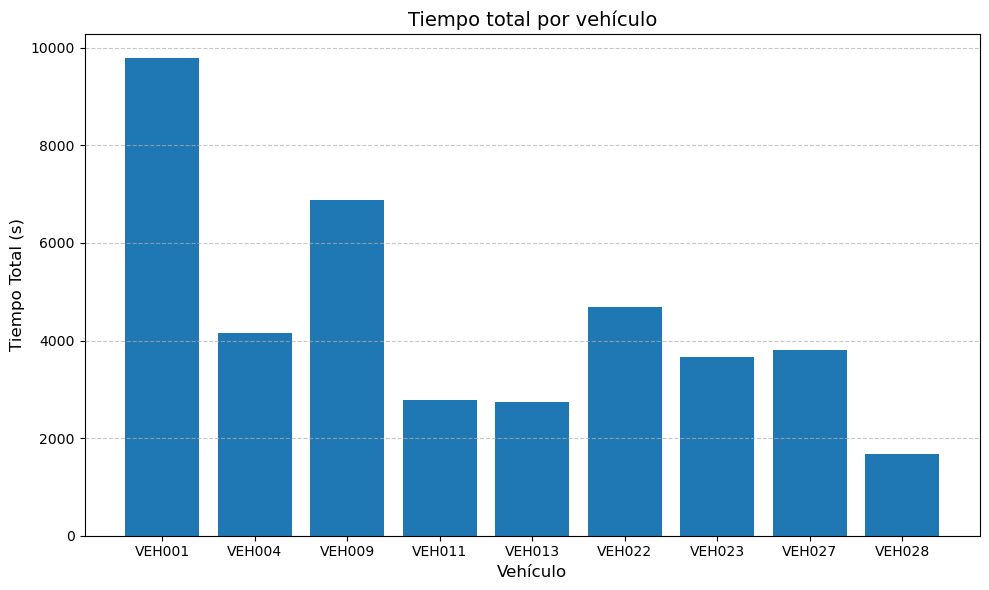

In [59]:
df_caso3 = pd.read_csv("verificacion_caso3.csv")

# Crear gráfica de barras a partir del tiempo total 
plt.figure(figsize=(10, 6))
plt.bar(df_caso3['VehicleId'], df_caso3['TotalTime'])

plt.title('Tiempo total por vehículo', fontsize=14)
plt.xlabel('Vehículo', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


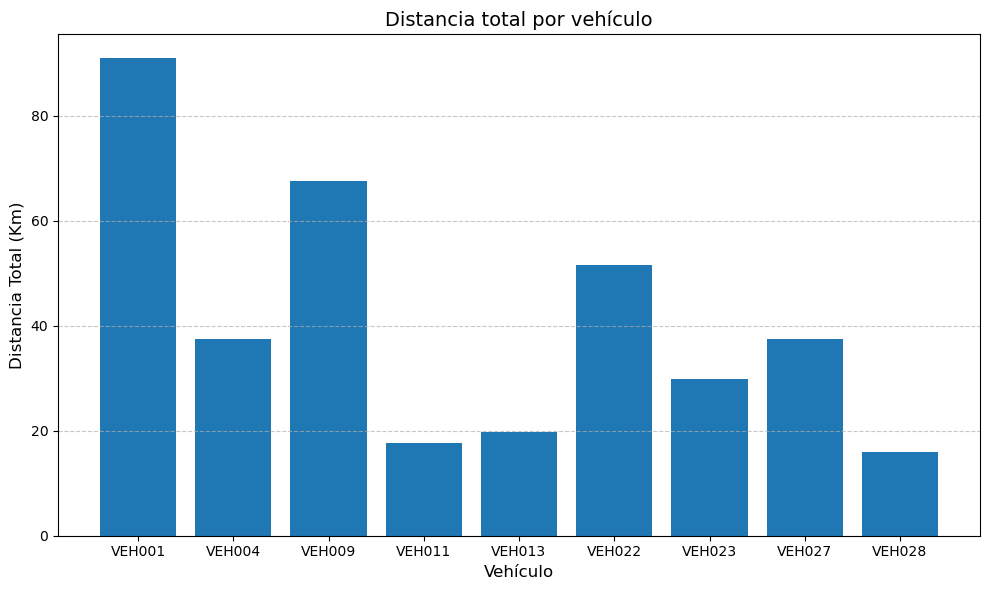

In [51]:
# Crear gráfica de barras a partir de la distancia total 
plt.figure(figsize=(10, 6))
plt.bar(df_caso3['VehicleId'], df_caso3['TotalDistance'])

plt.title('Distancia total por vehículo', fontsize=14)
plt.xlabel('Vehículo', fontsize=12)
plt.ylabel('Distancia Total (Km)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

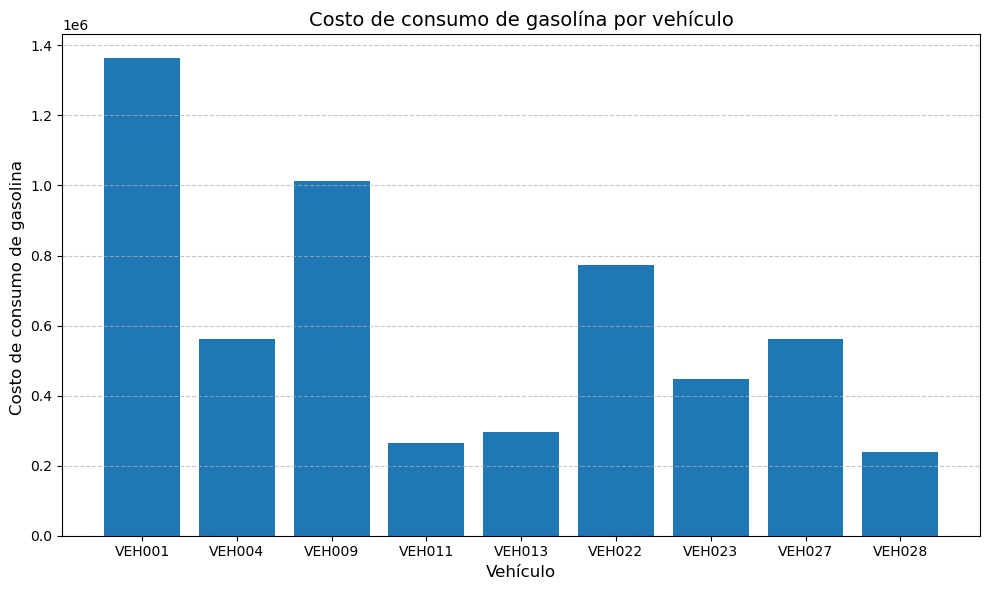

In [52]:
# Crear gráfica de barras a partir del tiempo total 
plt.figure(figsize=(10, 6))
plt.bar(df_caso3['VehicleId'], df_caso3['FuelCost'])

plt.title('Costo de consumo de gasolína por vehículo', fontsize=14)
plt.xlabel('Vehículo', fontsize=12)
plt.ylabel('Costo de consumo de gasolina ', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

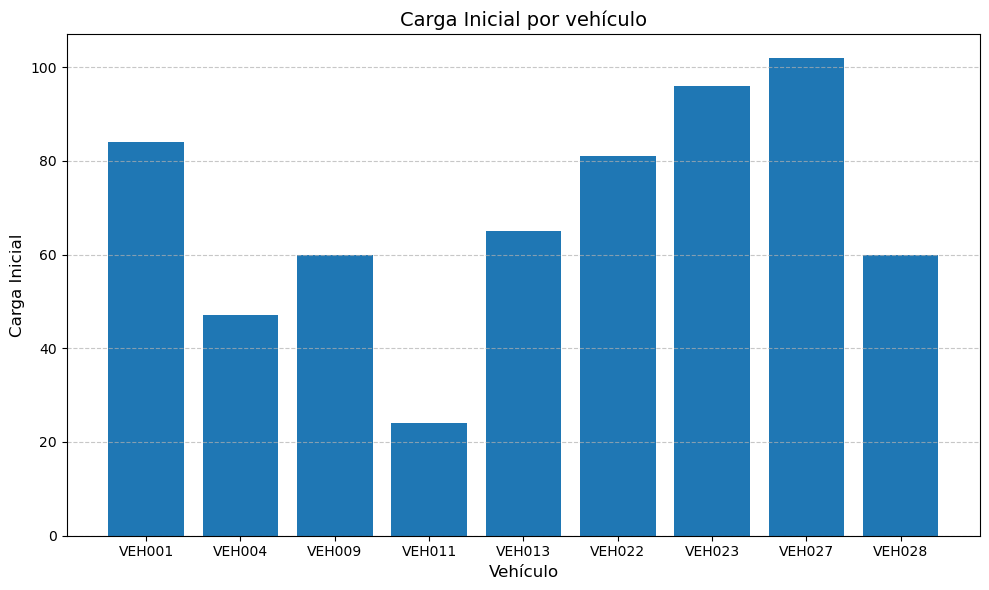

In [62]:
# Crear gráfica de barras a partir del tiempo total 
plt.figure(figsize=(10, 6))
plt.bar(df_caso3['VehicleId'], df_caso3['InitialLoad'])

plt.title('Carga Inicial por vehículo', fontsize=14)
plt.xlabel('Vehículo', fontsize=12)
plt.ylabel('Carga Inicial', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

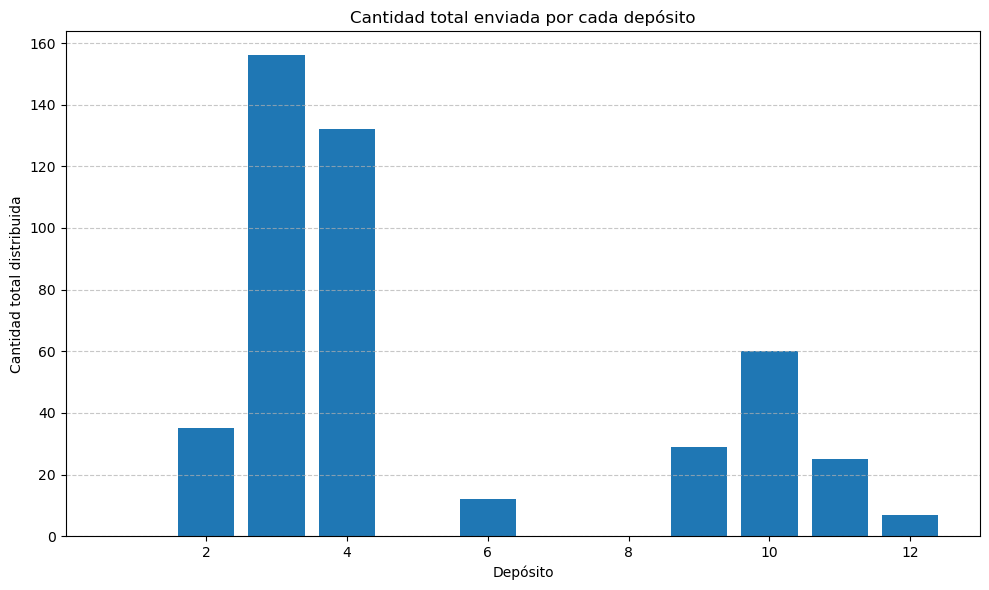

In [93]:
envio = {}
for d in model.D:
    envio[d] = 0

for k in model.K:
    arcos = []
    for (i, j, kk) in model.IndUs:
        if kk == k and model.x[i, j, kk].value is not None and model.x[i, j, kk].value > 0.5:
            arcos.append((i,j))

    if len(arcos) >= 1:
        inicio = arcos[0][0]

        for j in model.C:
            if model.y[j, k].value is not None and model.y[j, k].value > 0:
                envio[inicio] += model.y[j, k].value


depositos = list(envio.keys())
cantidades = [envio[d] for d in depositos]
plt.figure(figsize=(10, 6))
plt.bar(depositos, cantidades)
plt.xlabel("Depósito")
plt.ylabel("Cantidad total distribuida")
plt.title("Cantidad total enviada por cada depósito")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Estadísticas globales

In [88]:
distancias = df_caso3['TotalDistance']
print("Distancia total:", sum(distancias))
print("Distancia promedio por vehículo:", mean(distancias))
print("Desviación estándar de distancias:", stdev(distancias) if len(distancias) > 1 else 0)


Distancia total: 368.0999999999999
Distancia promedio por vehículo: 40.9
Desviación estándar de distancias: 25.217602978871724


In [89]:
cargas = df_caso3['InitialLoad']
print("Carga total:", sum(cargas))
print("Carga promedio por vehículo:", mean(cargas))
print("Desviación estándar de carga:", stdev(cargas) if len(cargas) > 1 else 0)


Carga total: 619.0
Carga promedio por vehículo: 68.77777777777777
Desviación estándar de carga: 24.681864687345737


In [86]:
df_caso3 = pd.read_csv("verificacion_caso3.csv")

tiempos = df_caso3['TotalTime']
print("Tiempo total estimado:", sum(tiempos))
print("Tiempo promedio por vehículo:", mean(tiempos))
print("Desviación estándar del tiempo:", stdev(tiempos) if len(tiempos) > 1 else 0)


Tiempo total estimado: 40195.100000000006
Tiempo promedio por vehículo: 4466.122222222222
Desviación estándar del tiempo: 2476.2526768172193
